In [1]:
from functools import partial

import numpy as np

np.set_printoptions(precision=3, suppress=True)

import matplotlib.pyplot as plt

import jax
from jax.flatten_util import ravel_pytree
from jax import numpy as jnp, random as jr, value_and_grad, tree_util

import optax

from env import Env
from svae.utils import split_into_batches, flat
from svae.models.ahmm import run_inference, init_pgm_param, rollout, onehot_sample, gumbel_softmax
from network import init_mlp, identity, make_loglike

In [2]:
key = jr.PRNGKey(123)
batch_dim = 64
num_epochs, num_samples, num_steps = 1000, 1000, 8

env = Env()

data_key, key = jr.split(key)
data, actions = env.sample(data_key, num_samples, num_steps)
data = data.reshape(num_samples, num_steps, -1)

batch_key, key = jr.split(key)
(data_batches, action_batches), num_batches = split_into_batches(batch_key, (data, actions), batch_dim)
get_batch = lambda i: data_batches[i % num_batches]
get_action_batch = lambda i: action_batches[i % num_batches]

In [3]:
def test(params, data, actions, env, key):
    infer_key, key = jr.split(key)
    pgm_params, decoder_params, encoder_params = params

    idx = np.random.randint(data.shape[0])
    test_data = data[idx : idx + 1, :]
    test_actions = actions[idx : idx + 1, :]

    node_potentials = encoder(encoder_params, test_data)
    samples, _, _, _ = run_inference(infer_key, pgm_prior_params, pgm_params, node_potentials, test_actions)
    decoded = decoder(decoder_params, samples)

    test_data_0, test_actions = test_data[0, 0, :], test_actions[0, :]
    node_potential_0 = encoder(encoder_params, test_data_0)
    probs = rollout(pgm_params, node_potential_0, test_actions)
    print(probs)
    sample_key, key = jr.split(key)
    samples = gumbel_softmax(jnp.log(probs), sample_key)
    decoded_rollout = decoder(decoder_params, samples)

    env.plot_sample(test_data.reshape(-1, 10, 10), test_actions)
    env.plot_sample(decoded.reshape(-1, 10, 10))
    env.plot_sample(decoded_rollout.reshape(-1, 10, 10))

    clipped_params = jnp.where(jnp.abs(pgm_params[1]) < 1.5, 0.0, params[0][1])
    fig, axs = plt.subplots(1, 4)
    axs[0].imshow(clipped_params[0])
    axs[1].imshow(clipped_params[1])
    axs[2].imshow(clipped_params[2])
    axs[3].imshow(clipped_params[3])
    axs[0].axis("off")
    axs[1].axis("off")
    axs[2].axis("off")
    axs[3].axis("off")
    plt.show()


def make_gradfun(
    key, run_inference, encoder, loglike, pgm_prior, num_samples, num_datapoints, num_batches, natgrad_scale=1.0
):
    _, unflat = ravel_pytree(pgm_prior)
    saved = lambda: None

    def mc_elbo(key, pgm_params, decoder_params, encoder_params, batch, actions):
        infer_key, key = jr.split(key)

        nn_potential = encoder(encoder_params, batch)
        samples, saved.stats, global_kl, local_kl = run_inference(
            infer_key, pgm_prior, pgm_params, nn_potential, actions, num_samples
        )
        return (
            num_batches * loglike(decoder_params, samples, batch) - global_kl - num_batches * local_kl
        ) / num_datapoints

    def gradfun(params, batch, actions):
        pgm_params, decoder_params, encoder_params = params
        objective = lambda decoder_params, encoder_params: -mc_elbo(
            key, pgm_params, decoder_params, encoder_params, batch, actions
        )
        elbo, (decoder_grad, encoder_grad) = value_and_grad(objective, argnums=(0, 1))(decoder_params, encoder_params)

        pgm_natgrad = (
            -natgrad_scale / num_datapoints * (flat(pgm_prior) + num_batches * flat(saved.stats) - flat(pgm_params))
        )
        return (unflat(pgm_natgrad), decoder_grad, encoder_grad), elbo

    return gradfun

epoch 0: 532.83
trans_probs
[[0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 ...
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]]
[[0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 ...
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]]
[[0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 ...
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]]
[[0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 ...
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]]
[[0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.0

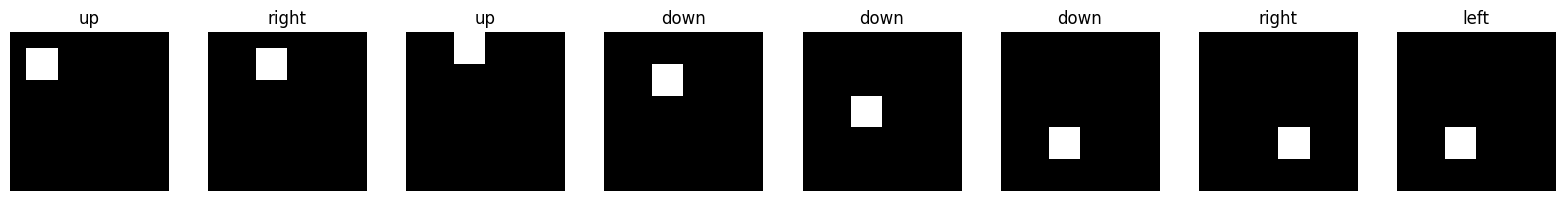

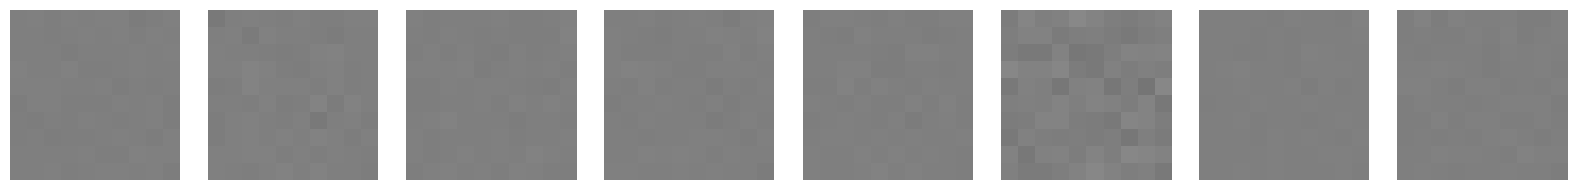

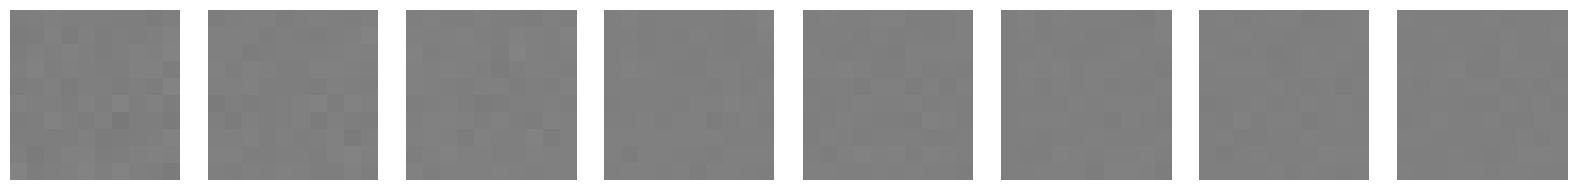

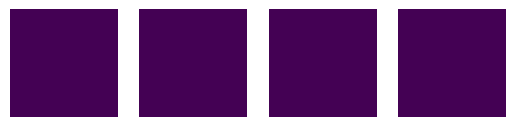

epoch 100: 115.41
trans_probs
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 

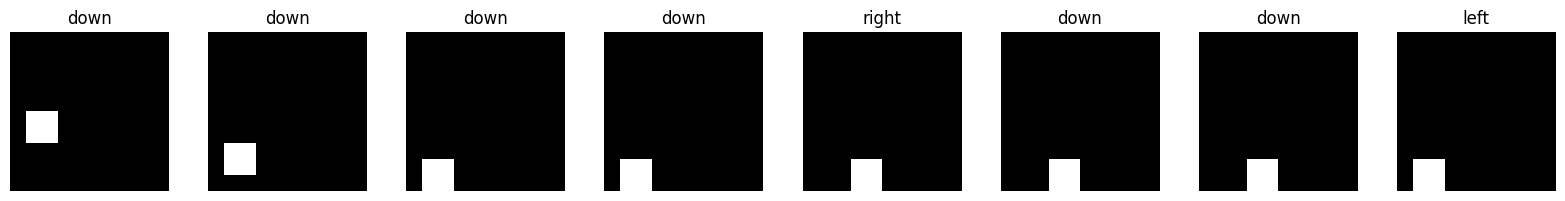

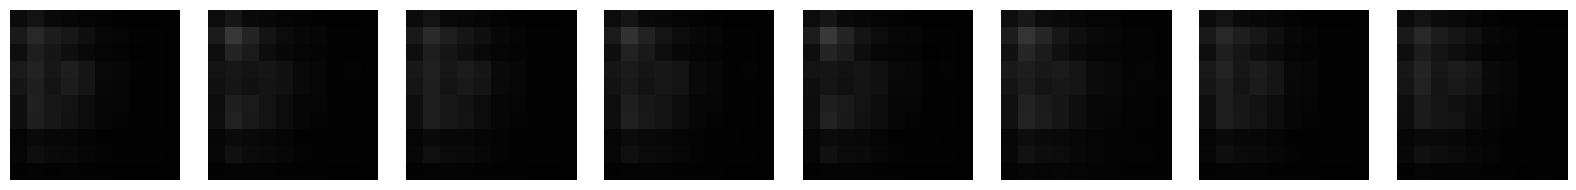

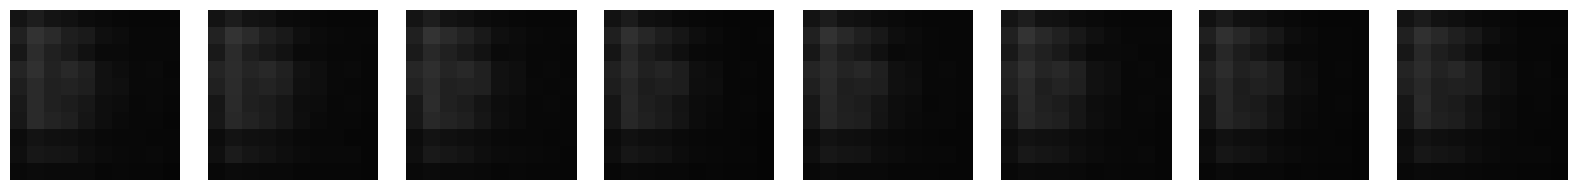

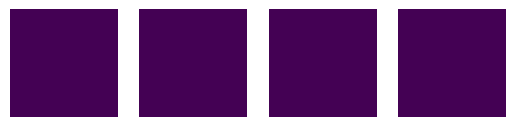

epoch 200: 84.90
trans_probs
[[0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.022 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.021 0.02 ]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.022 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]]
[[0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.023 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.021 0.02 ]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [

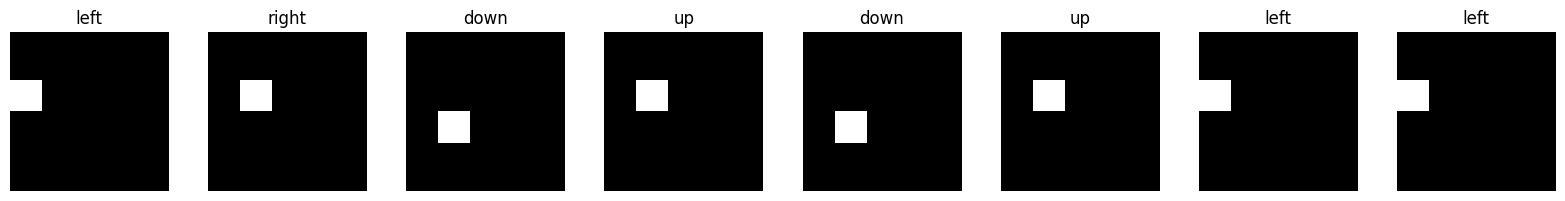

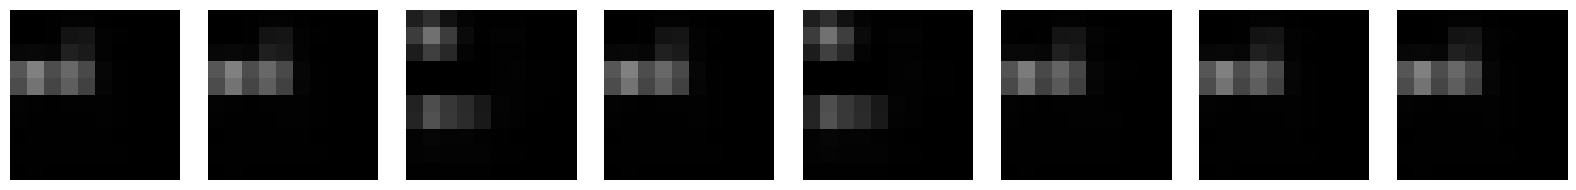

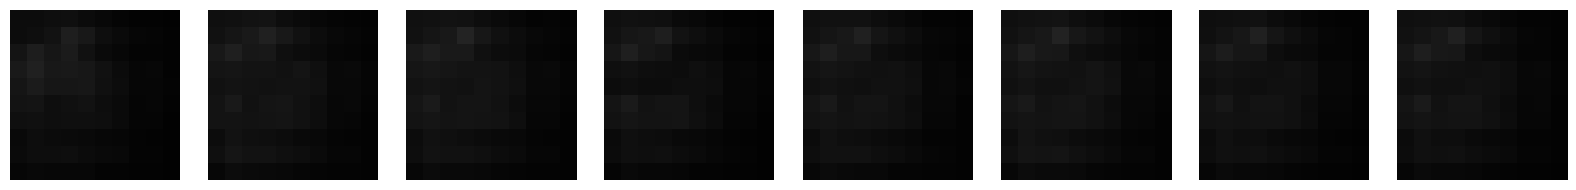

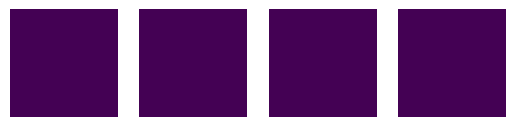

epoch 300: 77.11
trans_probs
[[0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.019 0.023 0.021]
 [0.02  0.02  0.02  ... 0.02  0.022 0.021]]
[[0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.019 0.023 0.021]
 [0.02  0.02  0.02  ... 0.02  0.021 0.021]]
[[0.02  0.02  0.02  ... 0.02  0.022 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.022 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.022 0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.022 0.02 ]
 [0.02  0.02  0.02  ... 0.019 0.024 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.023 0.02 ]]
[[0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [

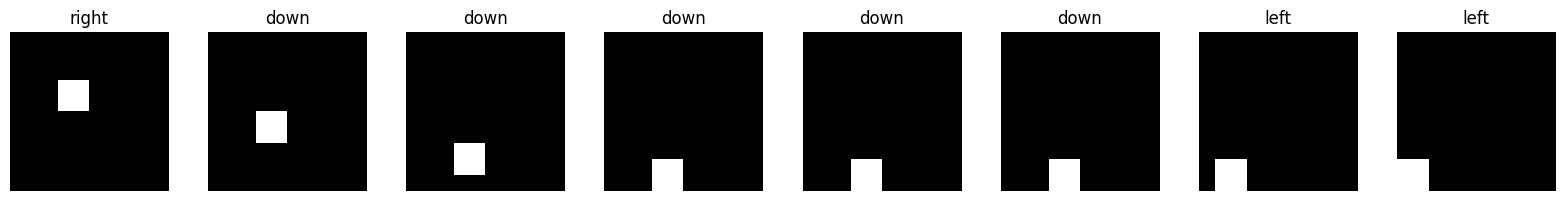

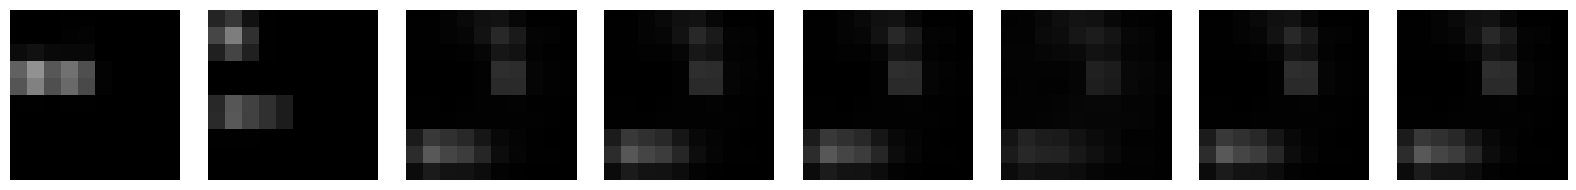

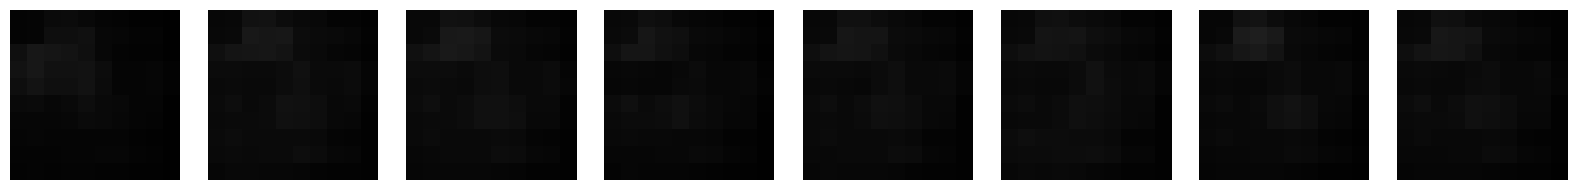

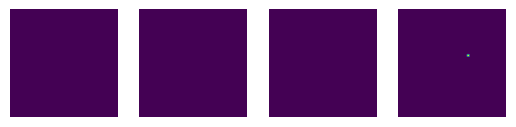

epoch 400: 70.49
trans_probs
[[0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.021 0.02  0.019 ... 0.019 0.024 0.023]
 [0.02  0.02  0.019 ... 0.02  0.023 0.022]]
[[0.02  0.02  0.02  ... 0.02  0.022 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.019 ... 0.019 0.025 0.022]
 [0.02  0.02  0.019 ... 0.02  0.024 0.022]]
[[0.02  0.02  0.02  ... 0.02  0.022 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.022 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.019 0.02  ... 0.019 0.025 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.024 0.021]]
[[0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [

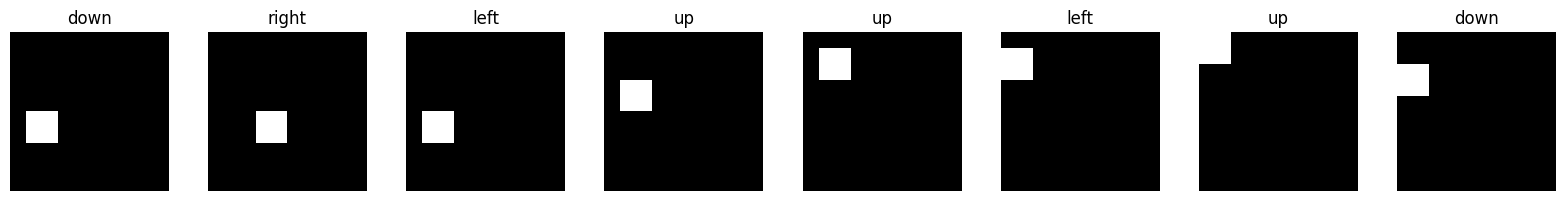

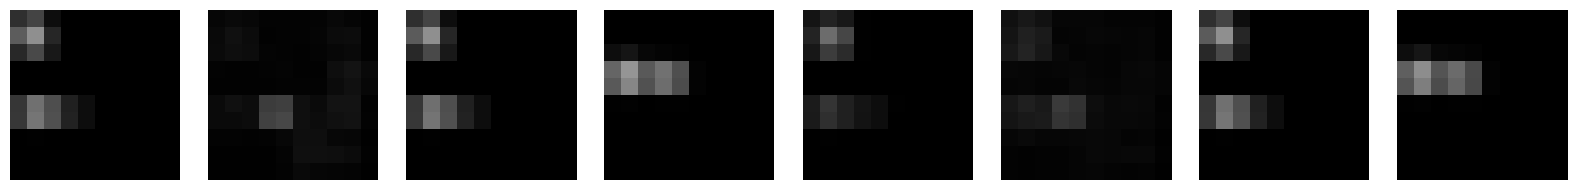

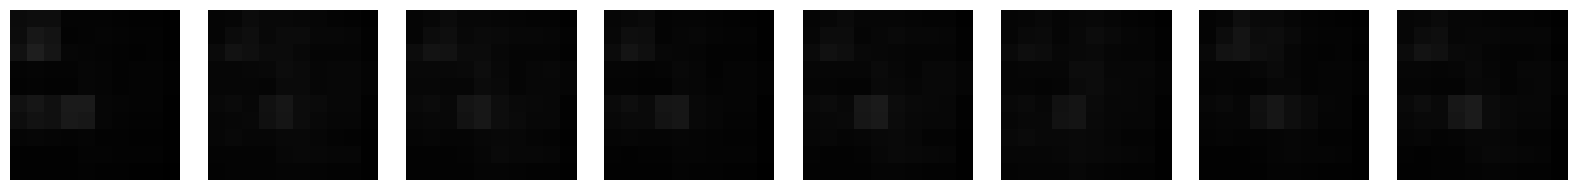

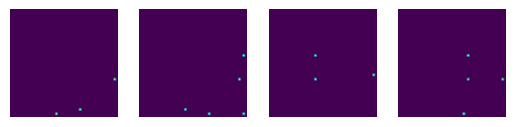

epoch 500: 61.15
trans_probs
[[0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.021 0.019 0.019 ... 0.019 0.024 0.026]
 [0.02  0.019 0.019 ... 0.019 0.025 0.022]]
[[0.02  0.02  0.02  ... 0.02  0.022 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.019 0.019 ... 0.019 0.026 0.025]
 [0.02  0.02  0.019 ... 0.019 0.028 0.023]]
[[0.02  0.02  0.02  ... 0.02  0.022 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.022 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.019 0.019 ... 0.019 0.026 0.02 ]
 [0.02  0.019 0.019 ... 0.019 0.025 0.024]]
[[0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [

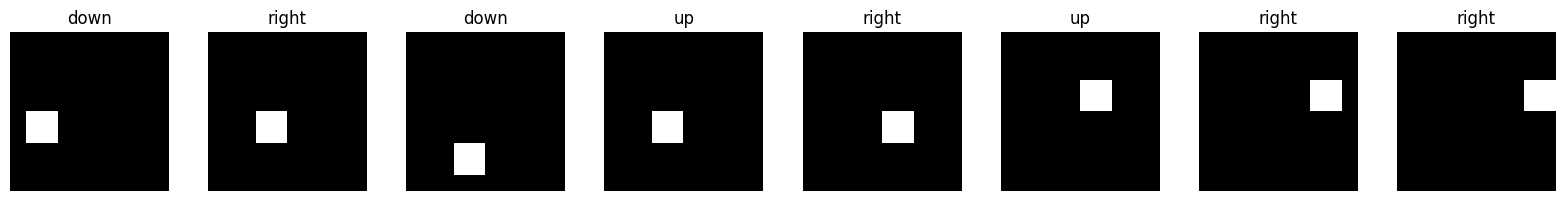

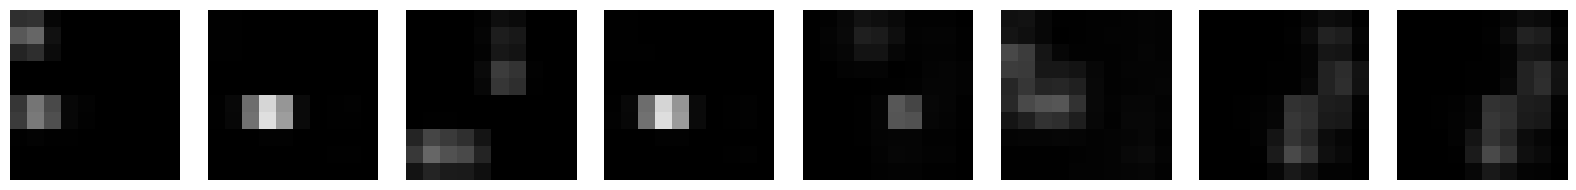

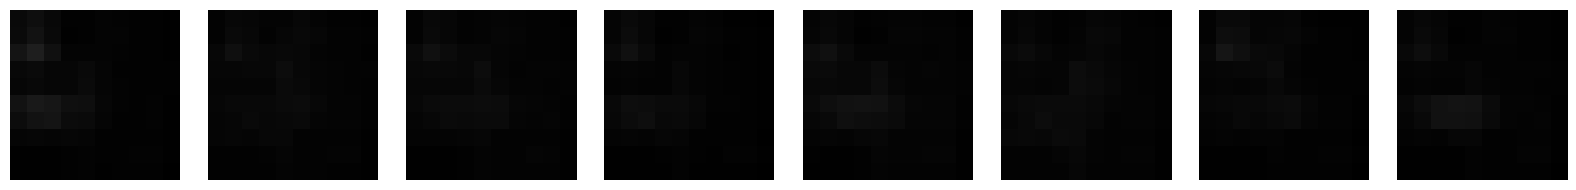

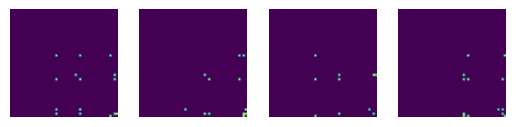

epoch 600: 48.87
trans_probs
[[0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.021 0.019 0.018 ... 0.018 0.025 0.028]
 [0.02  0.019 0.019 ... 0.019 0.026 0.022]]
[[0.02  0.02  0.02  ... 0.02  0.022 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.019 0.019 ... 0.019 0.027 0.027]
 [0.02  0.019 0.019 ... 0.019 0.03  0.023]]
[[0.02  0.02  0.02  ... 0.02  0.022 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.019 0.019 ... 0.019 0.027 0.02 ]
 [0.02  0.019 0.019 ... 0.019 0.025 0.027]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.021]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [

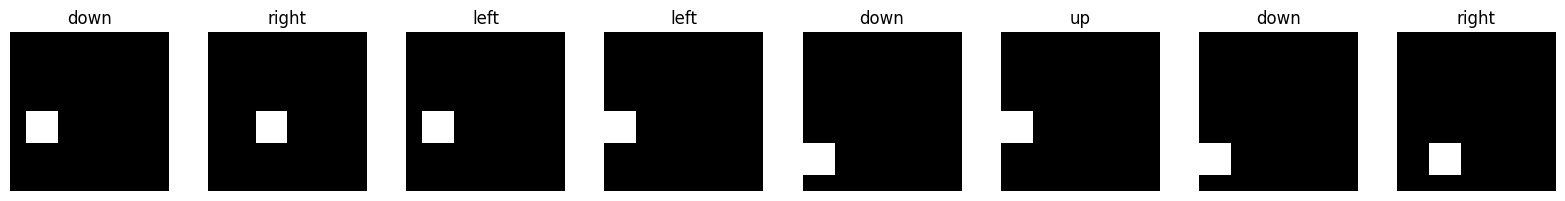

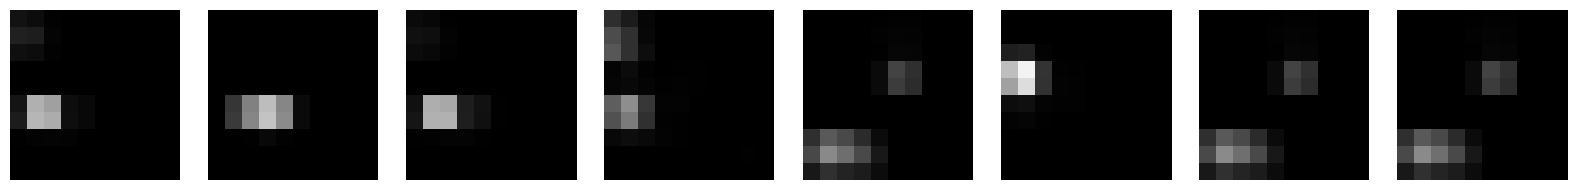

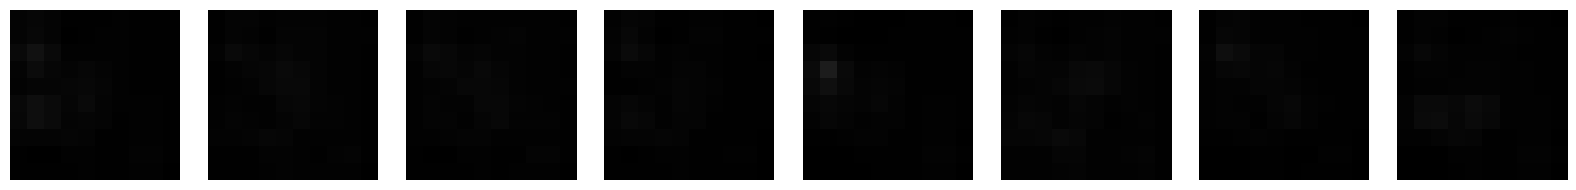

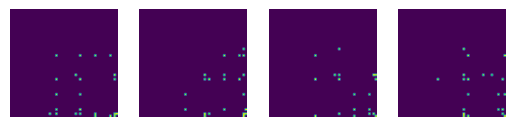

epoch 700: 41.20
trans_probs
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.019 0.018 ... 0.018 0.025 0.03 ]
 [0.019 0.019 0.019 ... 0.019 0.027 0.022]]
[[0.02  0.02  0.02  ... 0.02  0.022 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.019 0.019 0.019 ... 0.019 0.028 0.028]
 [0.02  0.019 0.019 ... 0.019 0.032 0.023]]
[[0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.019 0.019 0.019 ... 0.019 0.028 0.019]
 [0.019 0.019 0.019 ... 0.019 0.025 0.028]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [

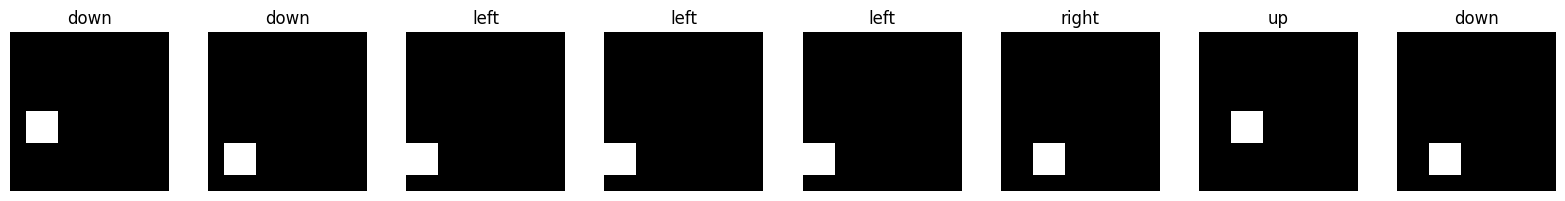

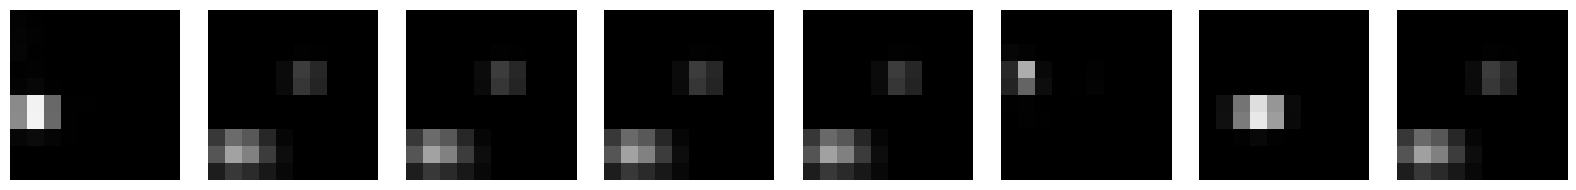

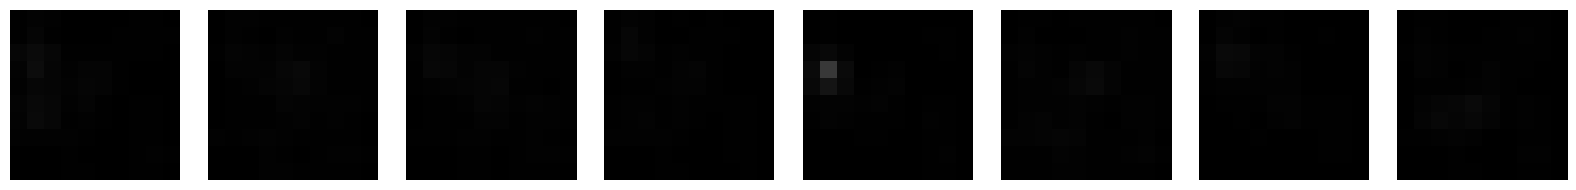

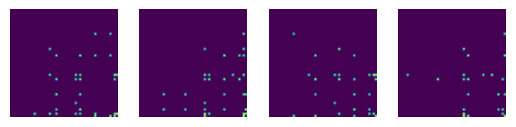

epoch 800: 31.63
trans_probs
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.018 0.018 ... 0.018 0.025 0.031]
 [0.019 0.019 0.019 ... 0.019 0.027 0.021]]
[[0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.019 0.019 0.019 ... 0.019 0.029 0.029]
 [0.019 0.019 0.019 ... 0.019 0.033 0.023]]
[[0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.019 0.019 0.019 ... 0.019 0.029 0.019]
 [0.019 0.019 0.019 ... 0.019 0.025 0.029]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [

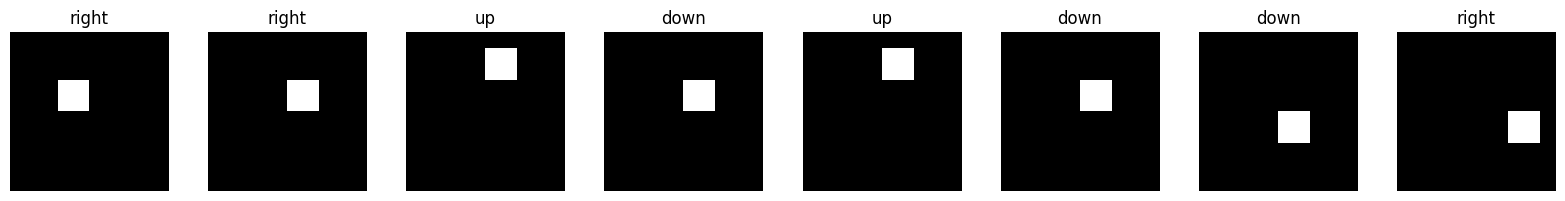

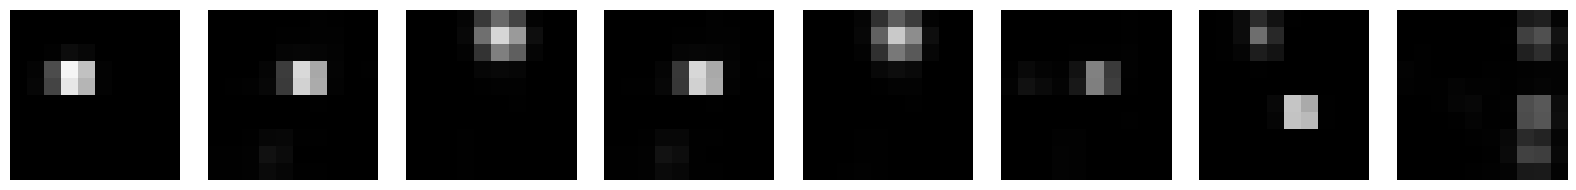

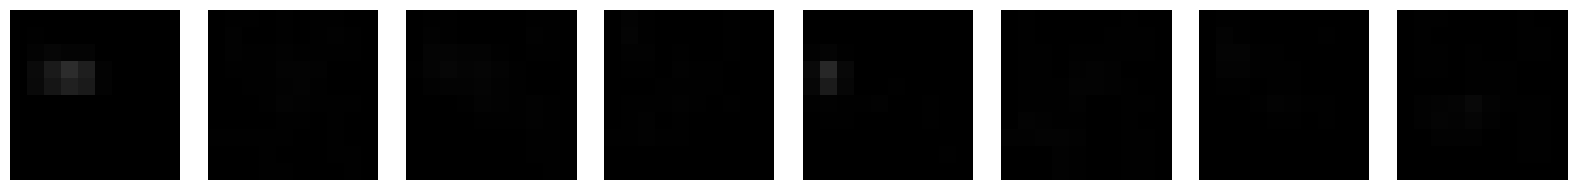

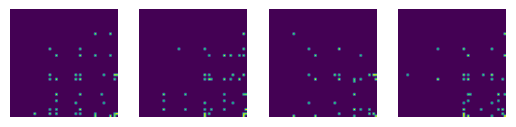

epoch 900: 27.72
trans_probs
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.018 0.018 ... 0.018 0.025 0.032]
 [0.019 0.019 0.019 ... 0.019 0.027 0.021]]
[[0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.019 0.019 0.019 ... 0.019 0.03  0.029]
 [0.019 0.019 0.019 ... 0.019 0.034 0.022]]
[[0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.019 0.019 0.019 ... 0.019 0.03  0.019]
 [0.019 0.019 0.019 ... 0.019 0.025 0.03 ]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [

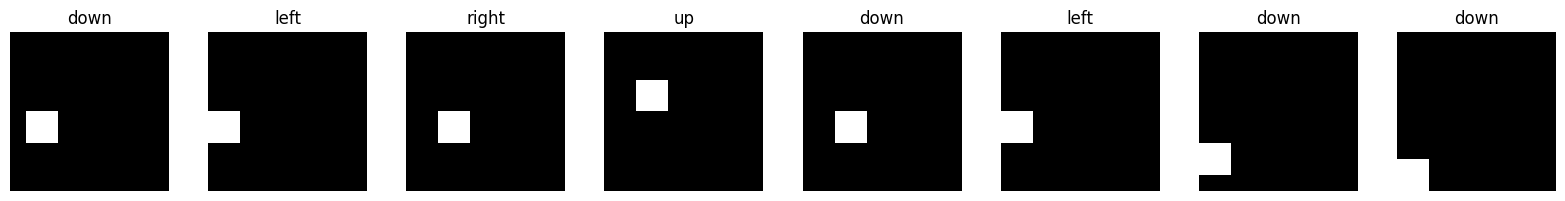

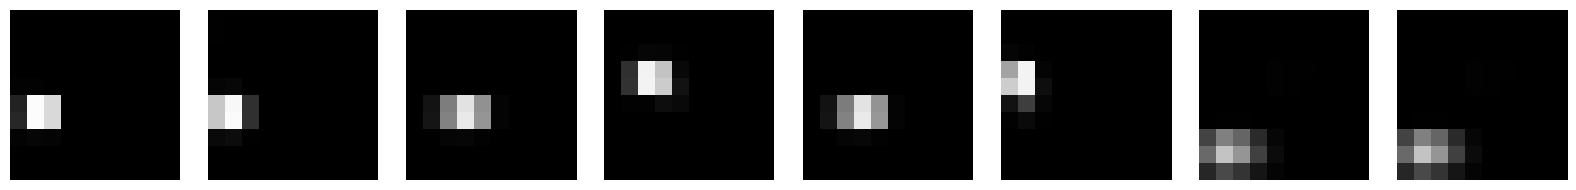

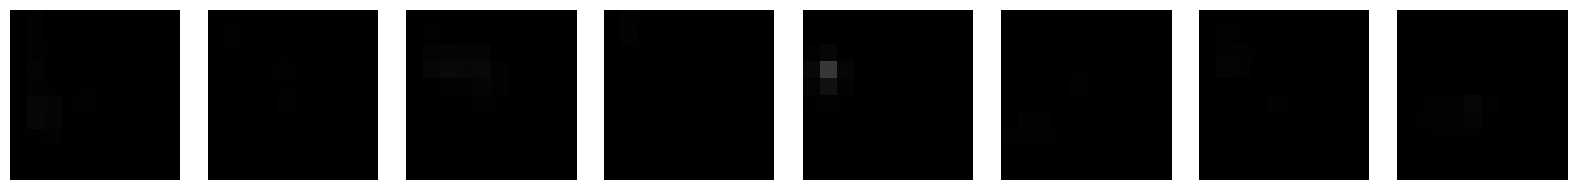

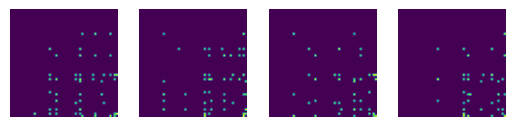

epoch 1000: 25.91
trans_probs
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.019 0.018 0.018 ... 0.018 0.025 0.033]
 [0.019 0.019 0.019 ... 0.021 0.027 0.021]]
[[0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.02  0.02  0.022]
 [0.019 0.019 0.019 ... 0.019 0.031 0.028]
 [0.019 0.019 0.019 ... 0.019 0.036 0.022]]
[[0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.023 0.019 0.02 ]
 [0.019 0.019 0.019 ... 0.019 0.031 0.019]
 [0.019 0.019 0.019 ... 0.019 0.026 0.031]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.02  0.02  0.02  ... 0.024 0.02  0.02 ]
 

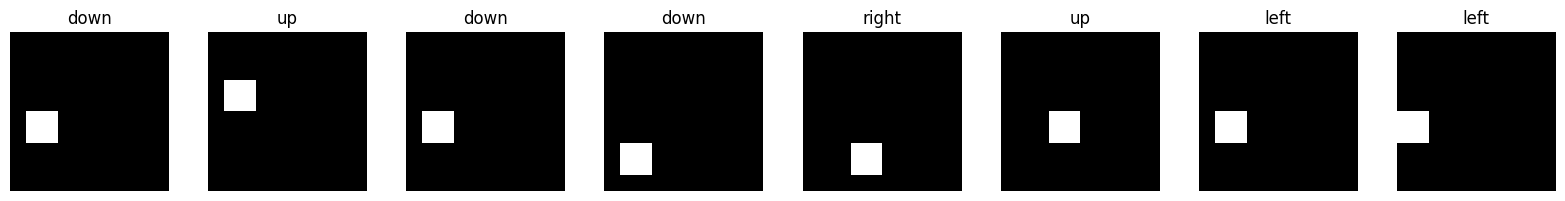

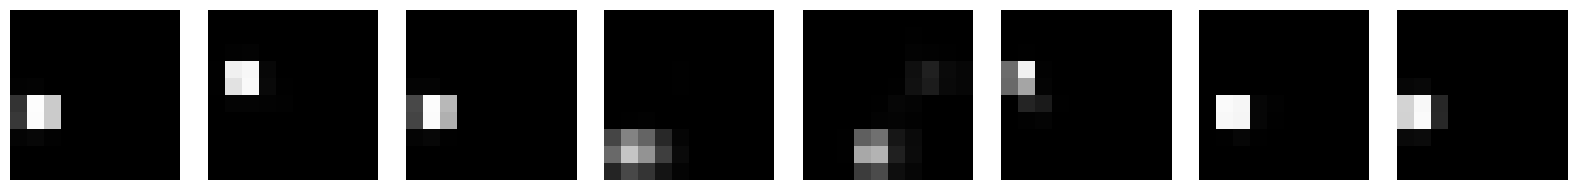

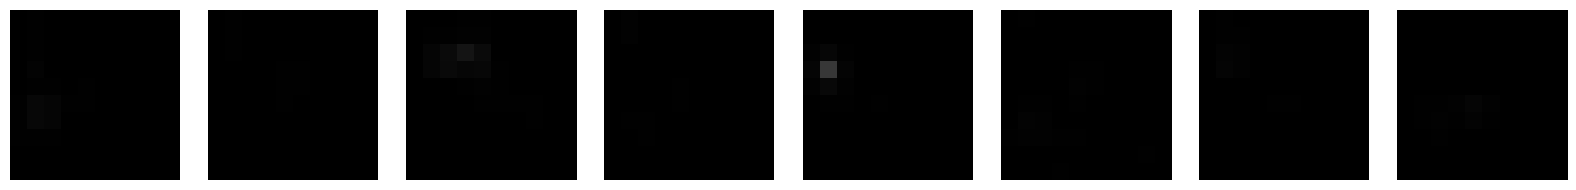

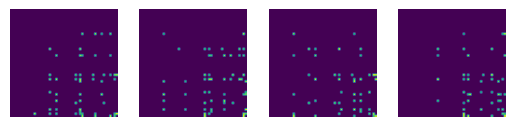

epoch 1100: 21.27
trans_probs
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.021 0.02  0.019]
 [0.019 0.018 0.018 ... 0.018 0.025 0.034]
 [0.019 0.019 0.019 ... 0.02  0.026 0.02 ]]
[[0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.021 0.019 0.023]
 [0.019 0.019 0.019 ... 0.019 0.032 0.028]
 [0.019 0.019 0.019 ... 0.019 0.037 0.022]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.023 0.019 0.019]
 [0.019 0.019 0.019 ... 0.019 0.032 0.02 ]
 [0.019 0.019 0.019 ... 0.019 0.026 0.032]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.025 0.02  0.02 ]
 

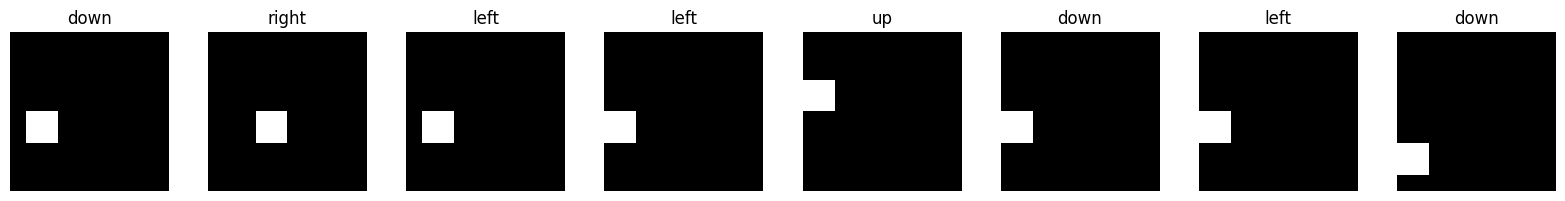

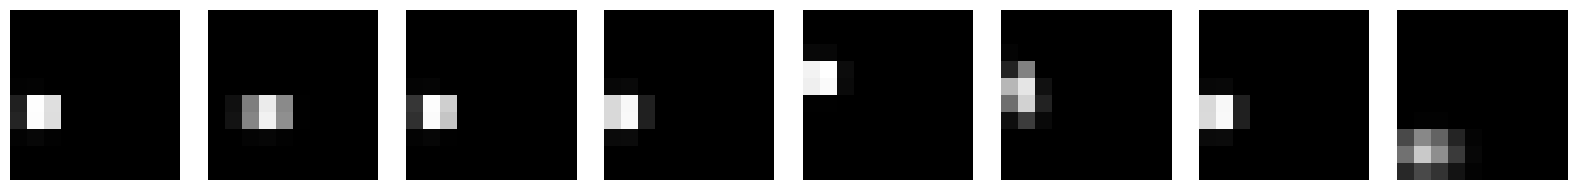

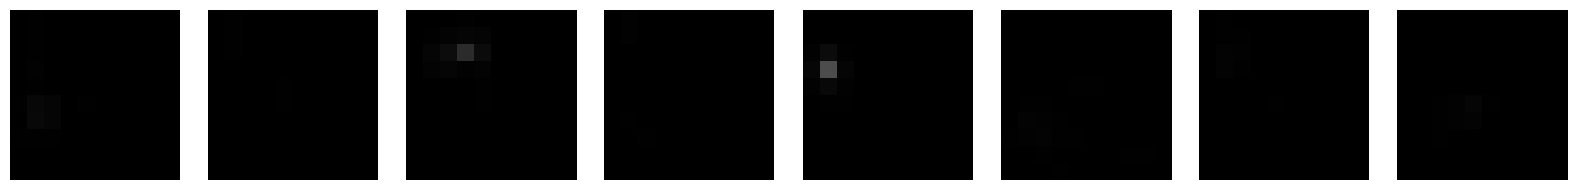

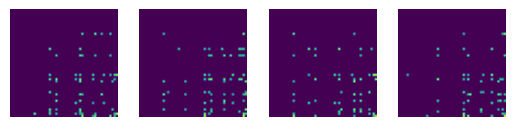

epoch 1200: 20.29
trans_probs
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.021 0.02  0.019]
 [0.019 0.018 0.018 ... 0.018 0.025 0.035]
 [0.018 0.018 0.018 ... 0.02  0.026 0.02 ]]
[[0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.02  0.019 0.022]
 [0.019 0.019 0.019 ... 0.019 0.033 0.028]
 [0.019 0.019 0.019 ... 0.019 0.038 0.022]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.023 0.019 0.019]
 [0.019 0.019 0.019 ... 0.019 0.033 0.02 ]
 [0.019 0.019 0.019 ... 0.02  0.027 0.033]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.026 0.019 0.021]
 

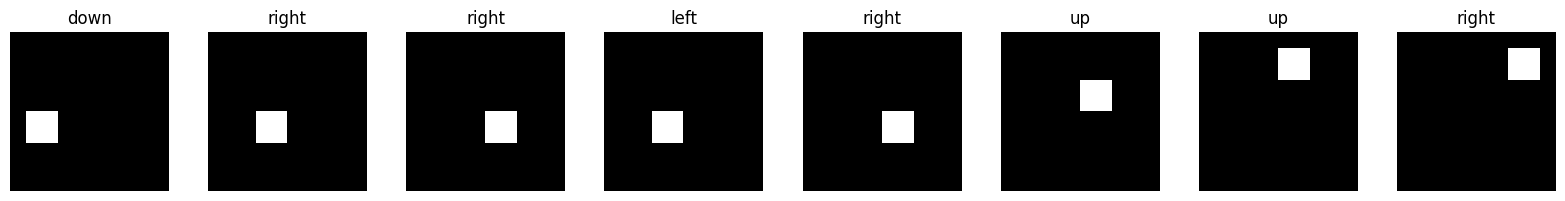

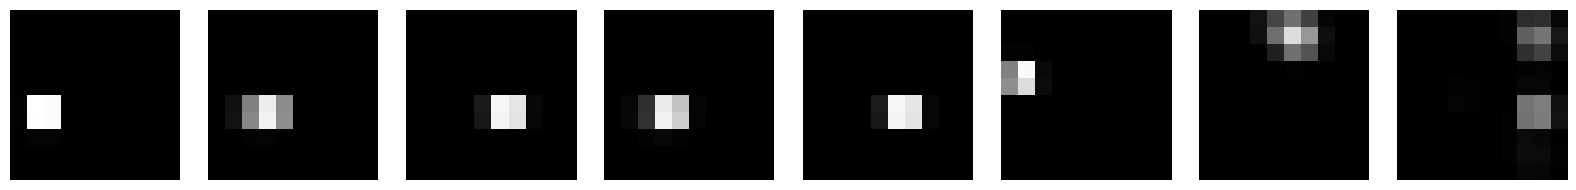

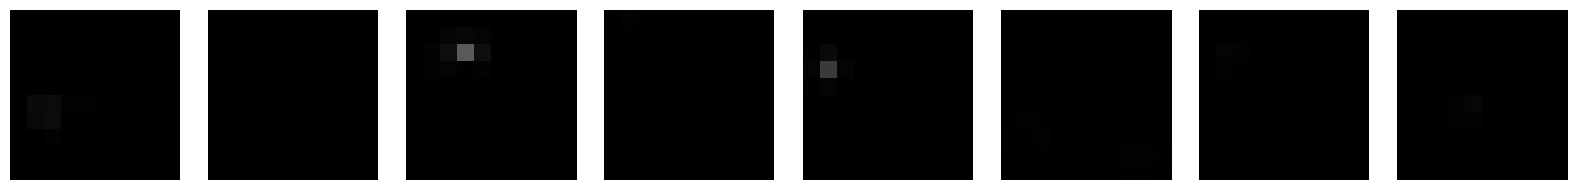

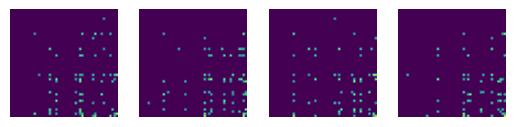

epoch 1300: 19.64
trans_probs
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.02  0.02  0.019]
 [0.019 0.018 0.018 ... 0.018 0.025 0.036]
 [0.018 0.018 0.018 ... 0.019 0.026 0.02 ]]
[[0.02  0.02  0.02  ... 0.02  0.021 0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.02  0.019 0.021]
 [0.019 0.019 0.019 ... 0.019 0.034 0.028]
 [0.019 0.019 0.019 ... 0.019 0.039 0.021]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.023 0.019 0.019]
 [0.019 0.019 0.019 ... 0.019 0.034 0.02 ]
 [0.019 0.018 0.018 ... 0.021 0.027 0.035]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.026 0.019 0.022]
 

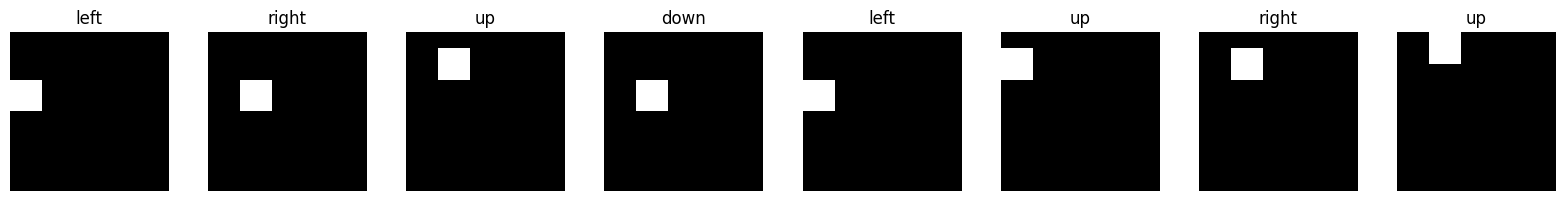

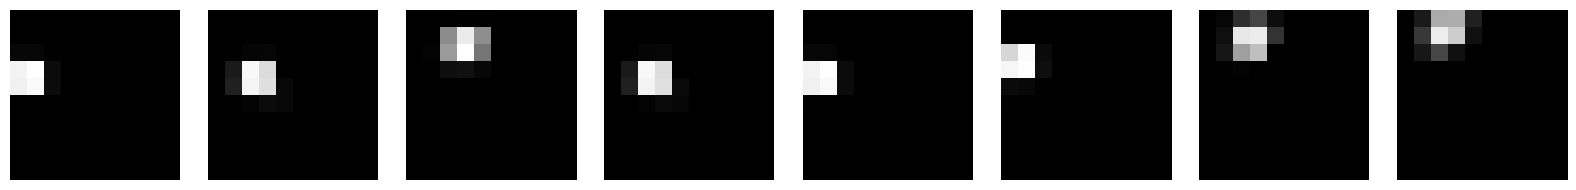

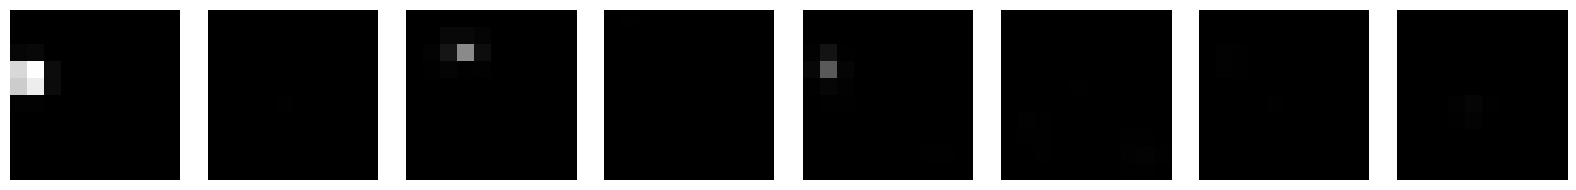

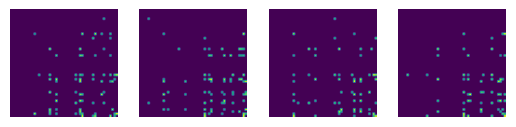

epoch 1400: 17.08
trans_probs
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.02  0.019 0.019]
 [0.018 0.018 0.018 ... 0.018 0.026 0.037]
 [0.018 0.018 0.018 ... 0.019 0.026 0.02 ]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.019 0.019 0.021]
 [0.019 0.019 0.019 ... 0.019 0.034 0.028]
 [0.019 0.019 0.019 ... 0.019 0.04  0.021]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.023 0.019 0.019]
 [0.019 0.019 0.019 ... 0.019 0.035 0.02 ]
 [0.018 0.018 0.018 ... 0.022 0.028 0.036]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.026 0.019 0.024]
 

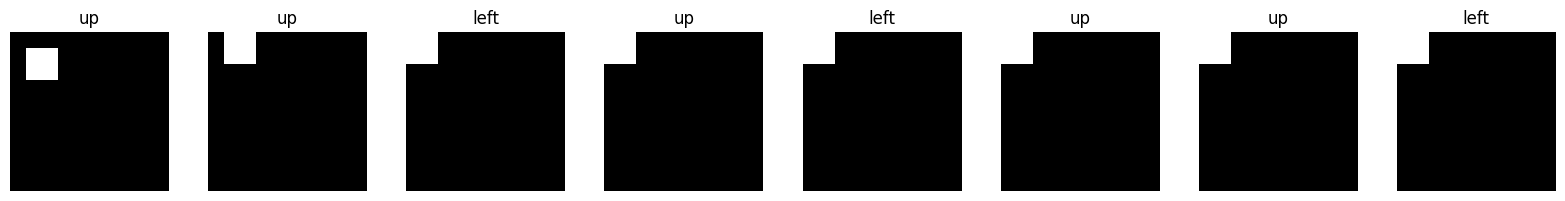

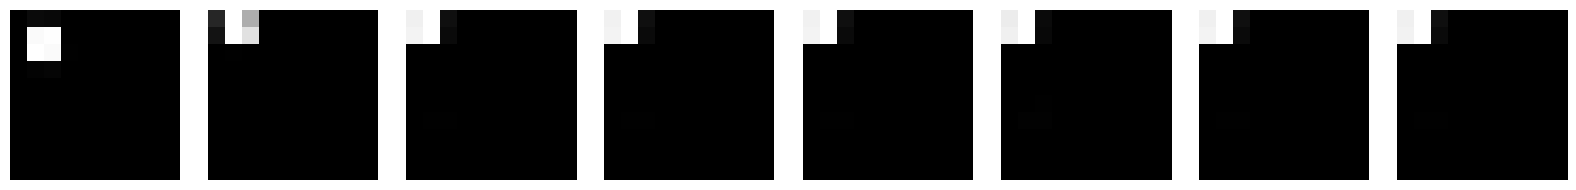

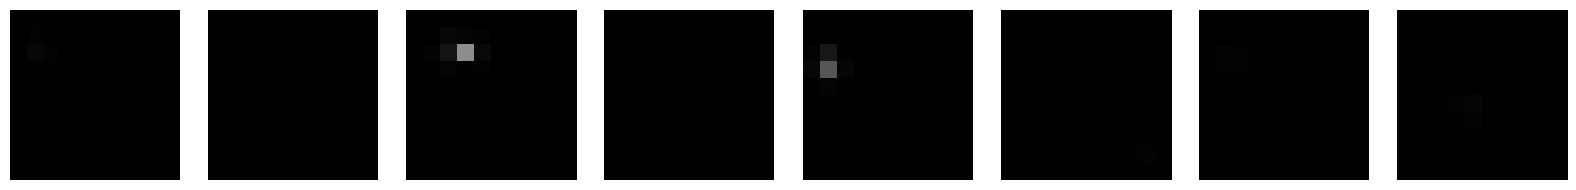

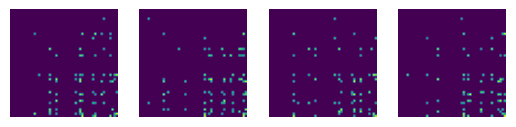

epoch 1500: 16.13
trans_probs
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.02  0.019 0.019]
 [0.018 0.018 0.018 ... 0.018 0.026 0.038]
 [0.018 0.018 0.018 ... 0.019 0.025 0.019]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.019 0.019 0.021]
 [0.019 0.018 0.018 ... 0.019 0.035 0.027]
 [0.019 0.019 0.019 ... 0.019 0.042 0.021]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.023 0.019 0.019]
 [0.019 0.019 0.019 ... 0.019 0.037 0.02 ]
 [0.018 0.018 0.018 ... 0.022 0.028 0.037]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.026 0.019 0.025]
 

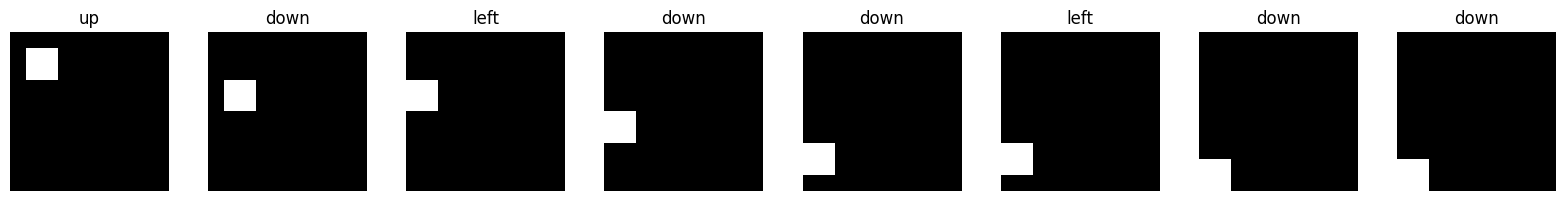

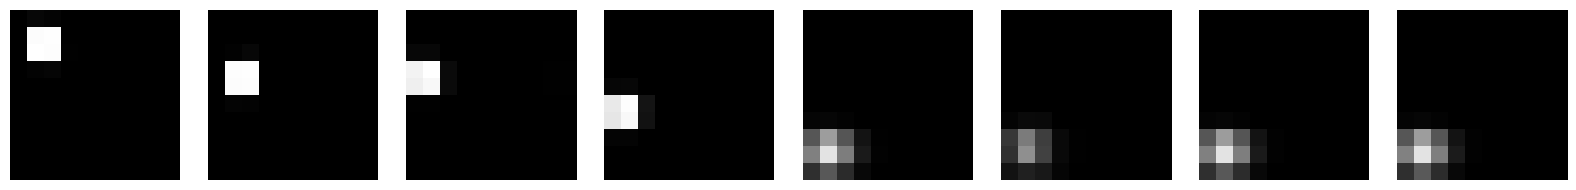

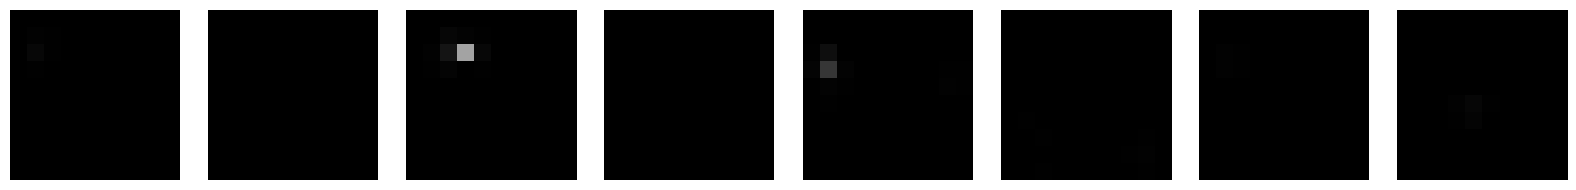

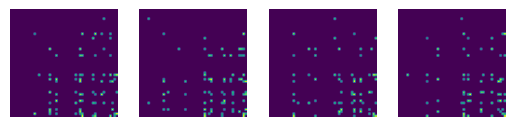

epoch 1600: 15.99
trans_probs
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.019 0.019 0.019]
 [0.018 0.018 0.018 ... 0.018 0.026 0.039]
 [0.018 0.018 0.018 ... 0.019 0.025 0.019]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.019 0.019 0.02 ]
 [0.018 0.018 0.018 ... 0.019 0.036 0.027]
 [0.019 0.019 0.019 ... 0.019 0.042 0.021]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.023 0.019 0.019]
 [0.019 0.019 0.019 ... 0.019 0.038 0.02 ]
 [0.018 0.018 0.018 ... 0.023 0.029 0.037]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.026 0.019 0.026]
 

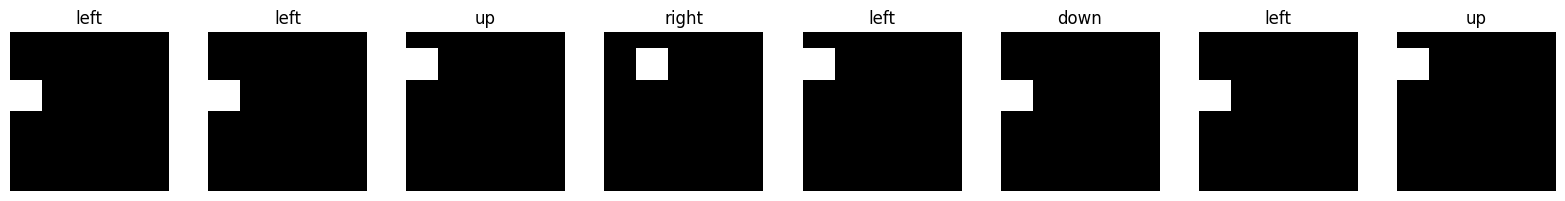

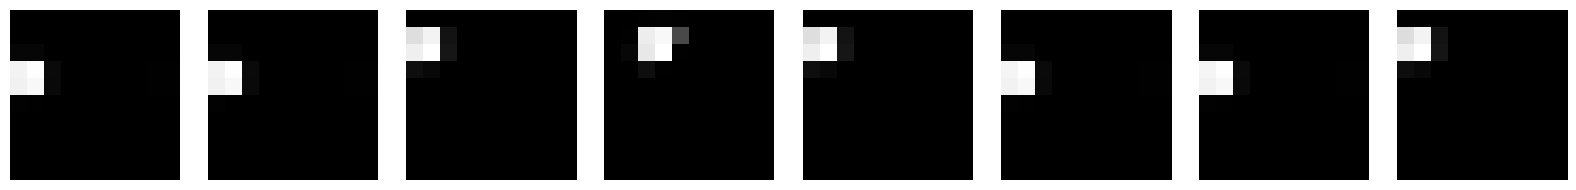

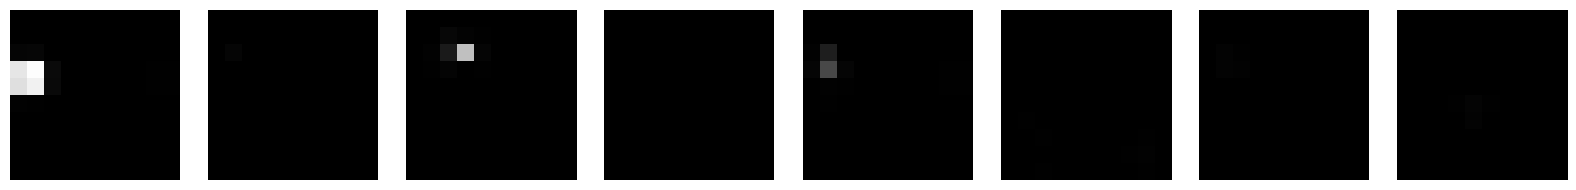

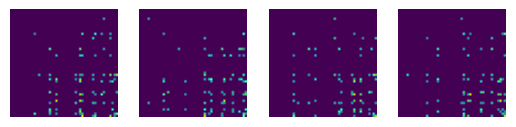

epoch 1700: 12.99
trans_probs
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.019 0.019 0.019]
 [0.018 0.017 0.017 ... 0.017 0.027 0.039]
 [0.018 0.018 0.018 ... 0.019 0.025 0.019]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.019 0.019 0.02 ]
 [0.018 0.018 0.018 ... 0.018 0.037 0.027]
 [0.018 0.018 0.018 ... 0.018 0.043 0.02 ]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.023 0.019 0.019]
 [0.019 0.019 0.019 ... 0.019 0.038 0.019]
 [0.018 0.018 0.018 ... 0.023 0.029 0.038]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.026 0.019 0.026]
 

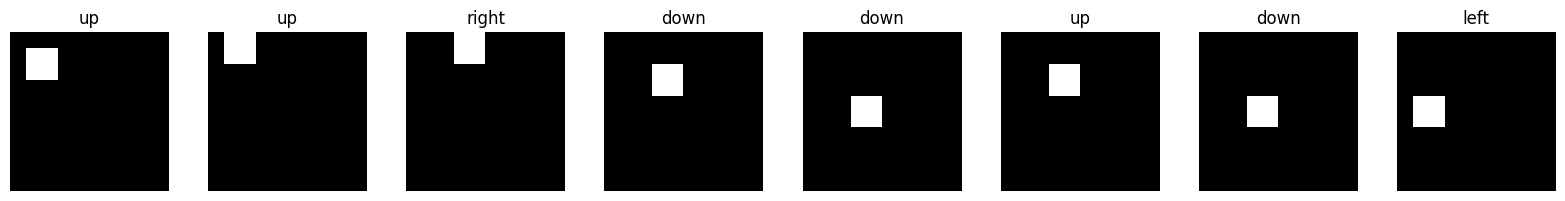

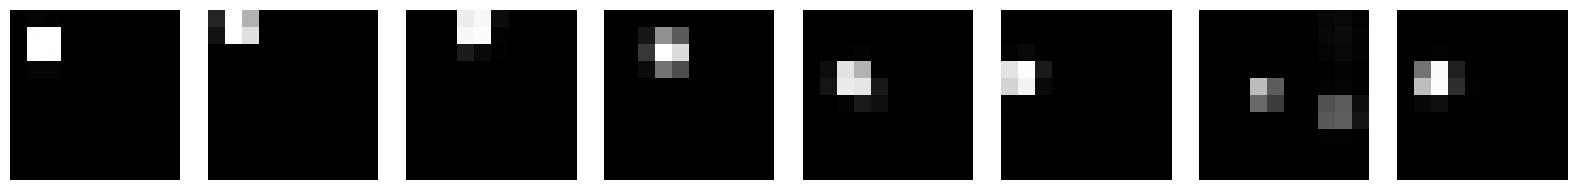

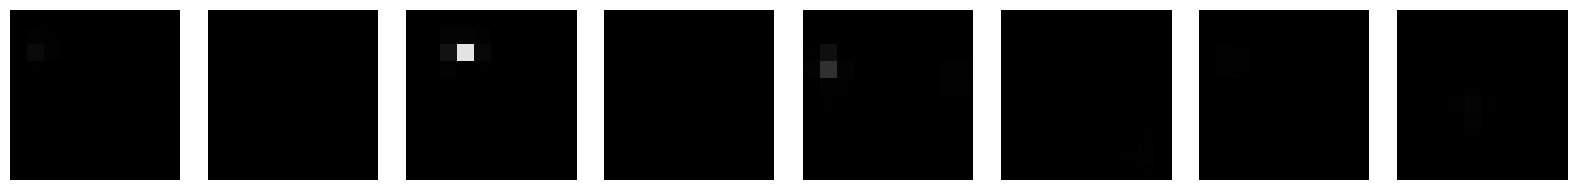

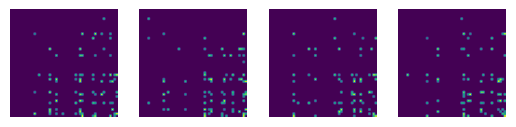

epoch 1800: 10.87
trans_probs
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.019 0.019 0.019]
 [0.018 0.017 0.017 ... 0.017 0.027 0.039]
 [0.018 0.018 0.018 ... 0.018 0.024 0.019]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.019 0.019 0.02 ]
 [0.018 0.018 0.018 ... 0.018 0.037 0.027]
 [0.018 0.018 0.018 ... 0.018 0.042 0.02 ]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.018 0.018 0.018 ... 0.023 0.018 0.018]
 [0.019 0.019 0.019 ... 0.019 0.039 0.019]
 [0.018 0.018 0.018 ... 0.024 0.029 0.039]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.026 0.019 0.027]
 

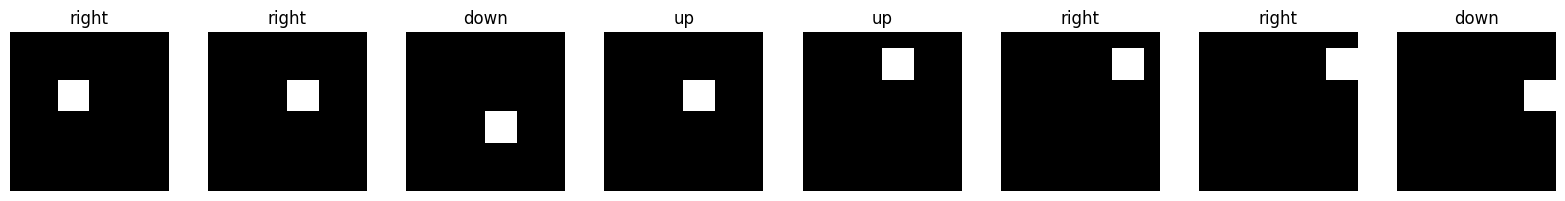

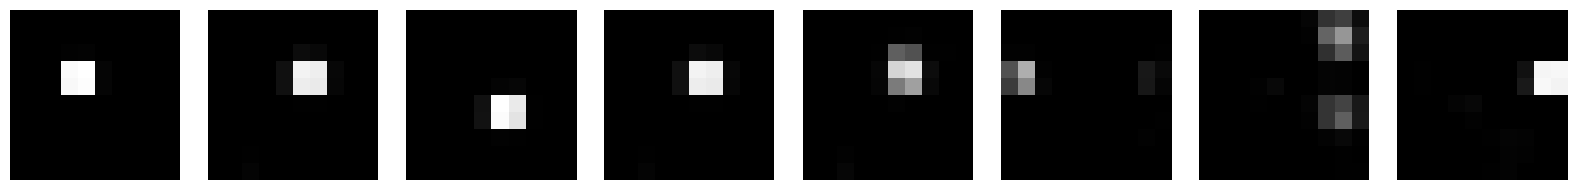

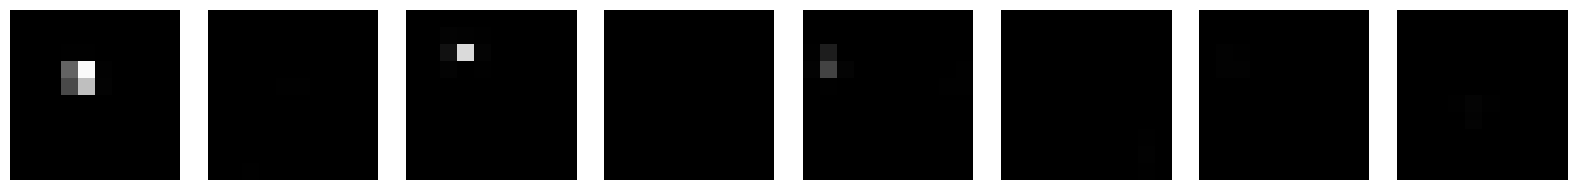

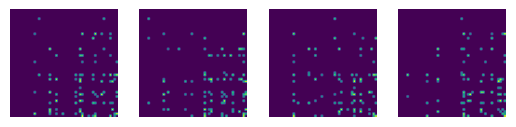

epoch 1900: 9.96
trans_probs
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.019 0.019 0.019]
 [0.018 0.017 0.017 ... 0.017 0.027 0.04 ]
 [0.018 0.018 0.018 ... 0.018 0.024 0.019]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.019 0.019 0.02 ]
 [0.018 0.018 0.018 ... 0.018 0.038 0.026]
 [0.018 0.018 0.018 ... 0.018 0.042 0.02 ]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.018 0.018 0.018 ... 0.022 0.018 0.018]
 [0.019 0.019 0.019 ... 0.019 0.04  0.019]
 [0.018 0.018 0.018 ... 0.025 0.028 0.04 ]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.026 0.019 0.028]
 [

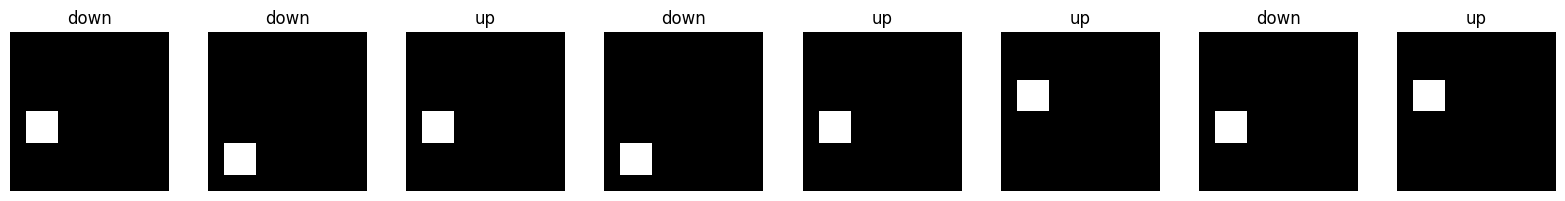

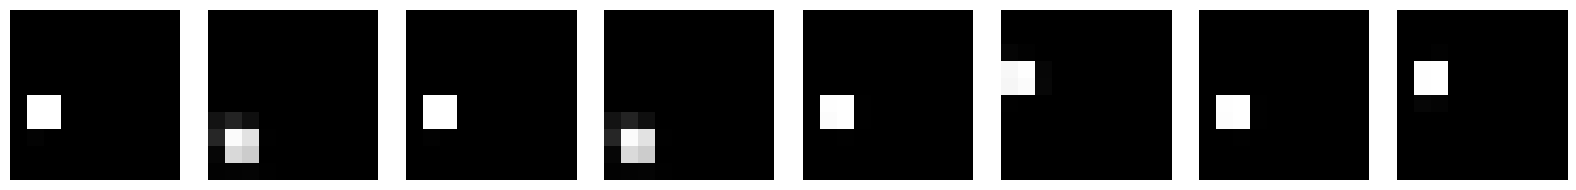

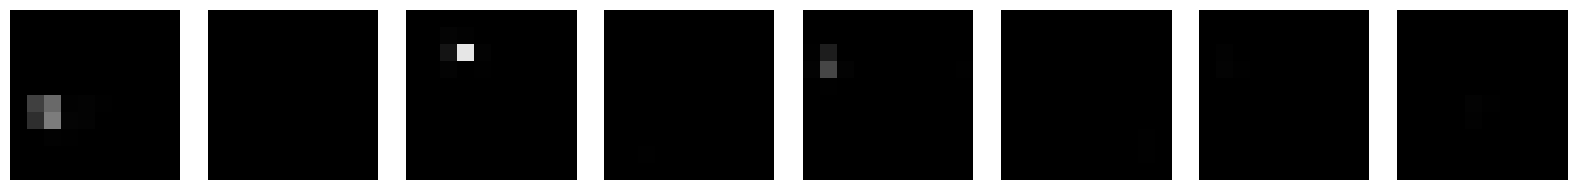

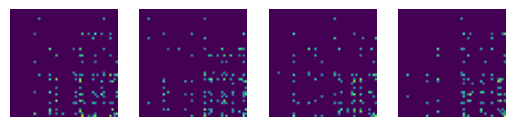

epoch 2000: 8.86
trans_probs
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.019 0.019 0.019]
 [0.017 0.017 0.017 ... 0.017 0.027 0.04 ]
 [0.018 0.018 0.018 ... 0.018 0.023 0.018]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.019 0.019 0.02 ]
 [0.018 0.018 0.018 ... 0.018 0.038 0.026]
 [0.018 0.018 0.018 ... 0.018 0.042 0.019]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.018 0.018 0.018 ... 0.022 0.018 0.018]
 [0.019 0.019 0.019 ... 0.019 0.04  0.019]
 [0.018 0.018 0.018 ... 0.026 0.028 0.041]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.026 0.019 0.029]
 [

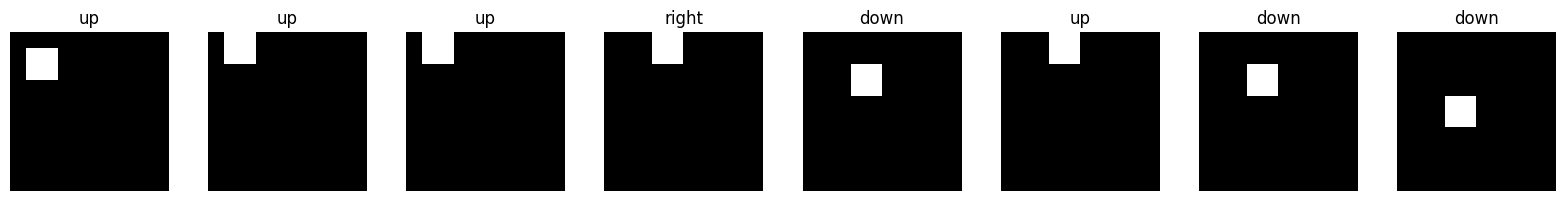

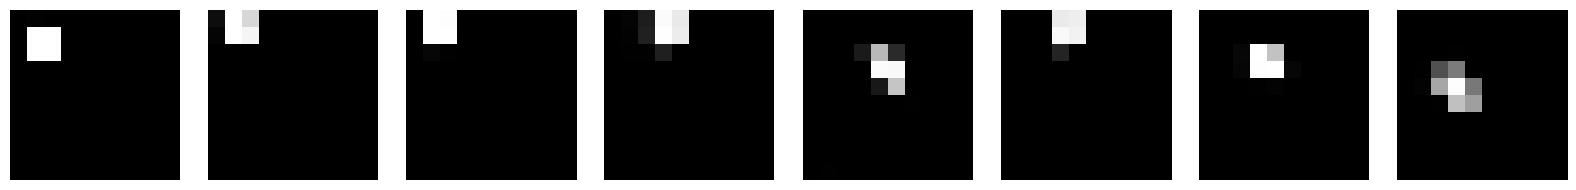

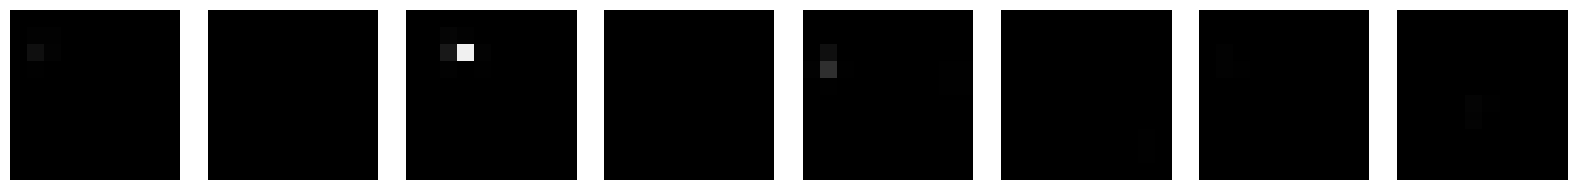

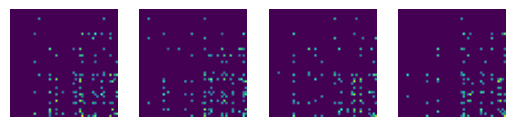

epoch 2100: 7.27
trans_probs
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.019 0.019 0.019]
 [0.017 0.017 0.017 ... 0.017 0.027 0.04 ]
 [0.018 0.018 0.018 ... 0.018 0.023 0.018]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.019 0.019 0.02 ]
 [0.018 0.018 0.018 ... 0.018 0.039 0.026]
 [0.018 0.018 0.018 ... 0.018 0.042 0.019]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.018 0.018 0.018 ... 0.022 0.018 0.018]
 [0.019 0.019 0.019 ... 0.019 0.041 0.019]
 [0.018 0.018 0.018 ... 0.027 0.027 0.042]]
[[0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 [0.02  0.02  0.02  ... 0.02  0.02  0.02 ]
 ...
 [0.019 0.019 0.019 ... 0.026 0.019 0.031]
 [

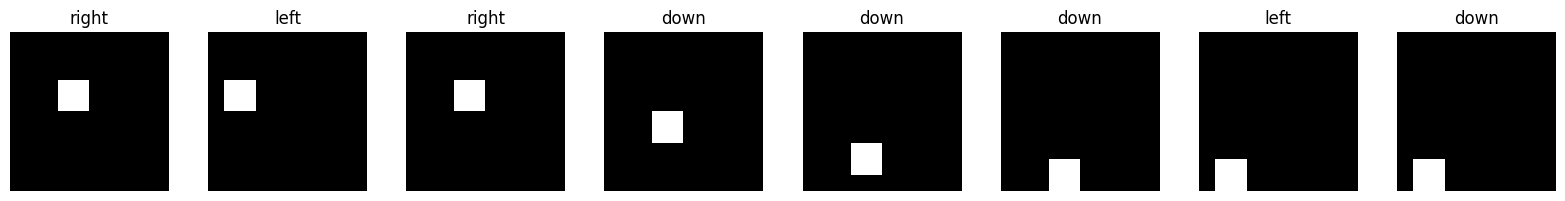

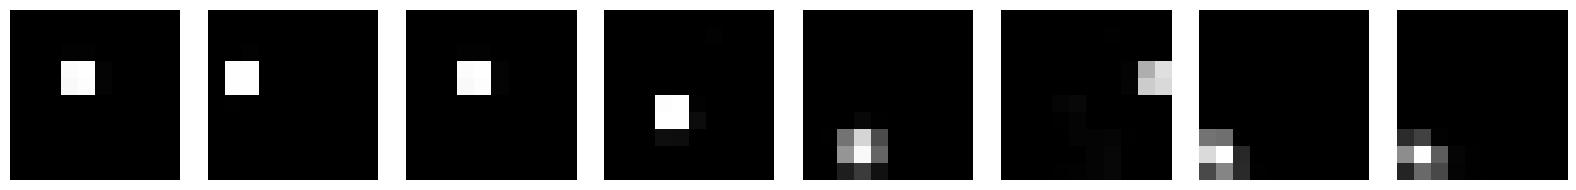

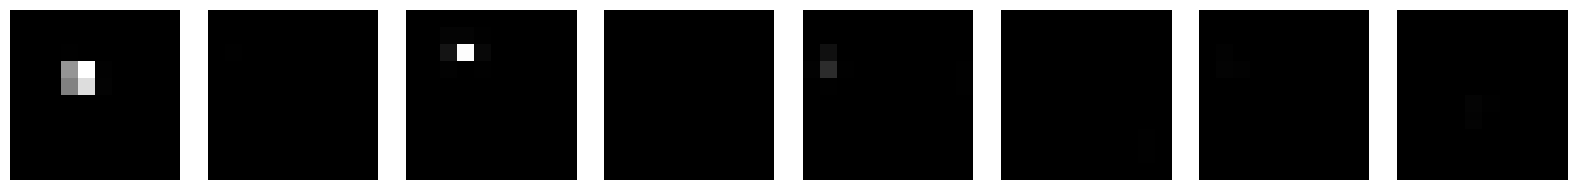

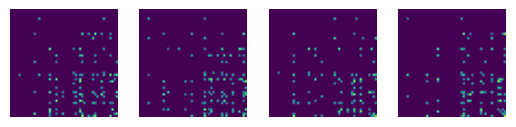

epoch 2200: nan
trans_probs
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan na

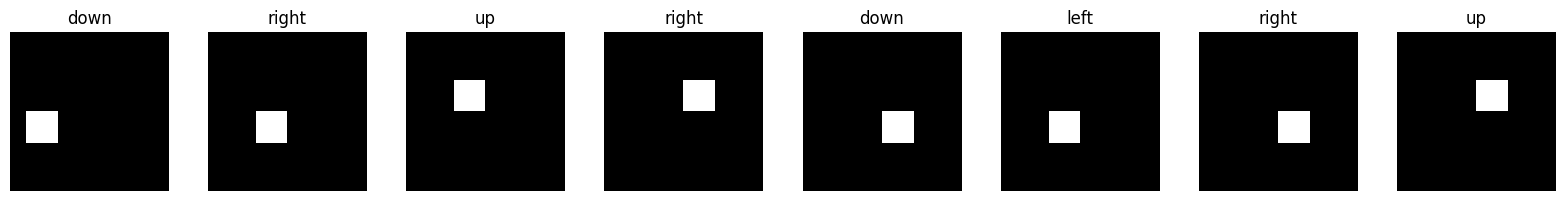

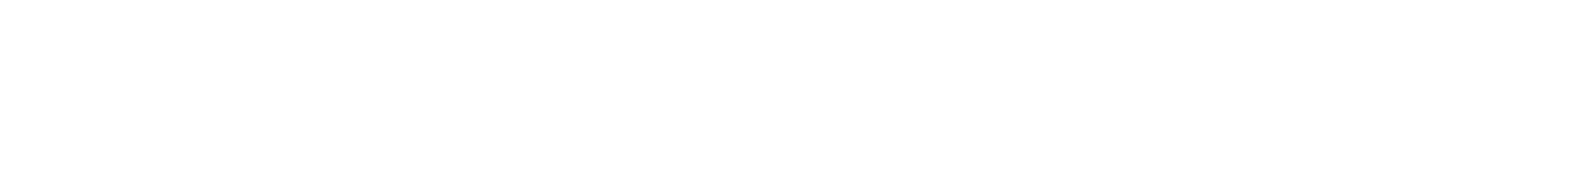

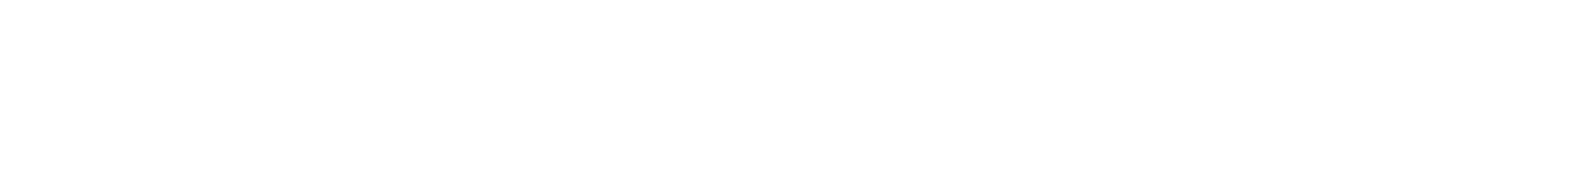

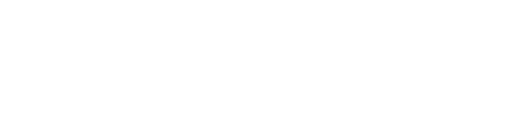

KeyboardInterrupt: 

In [4]:
num_epochs = 5000
A, K, D = 4, 50, 100

prior_key, key = jr.split(key)
pgm_prior_params = init_pgm_param(prior_key, K, A, alpha=0.0)

encoder_key, key = jr.split(key)
encoder, encoder_params = init_mlp(encoder_key, D, [(512, jax.nn.relu), (K, identity)])

decoder_key, key = jr.split(key)
decoder, decoder_params = init_mlp(decoder_key, K, [(512, jax.nn.relu), (D, jax.nn.sigmoid)])
loglike = make_loglike(decoder)

pgm_key, key = jr.split(key)
pgm_params = init_pgm_param(pgm_key, K, A, alpha=0.0)
params = pgm_params, decoder_params, encoder_params

grad_key, key = jr.split(key)
gradfun = make_gradfun(grad_key, run_inference, encoder, loglike, pgm_prior_params, 1, num_samples, num_batches, 1e6)

optim = optax.adamw(learning_rate=1e-3)
opt_state = optim.init(params)

for epoch in range(num_epochs):
    grads, elbo = gradfun(params, get_batch(epoch), get_action_batch(epoch))
    updates, opt_state = optim.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    if epoch % 100 == 0:
        print(f"epoch {epoch}: {elbo:.2f}")
        test(params, data, actions, env, key)